In [1]:
#https://www.mlflow.org/docs/latest/tutorials-and-examples/tutorial.html
#https://pedro-munoz.tech/how-to-setup-mlflow-in-production/
import os
import warnings
import sys

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import git

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)
from mlflow import MlflowClient


sys.path.append('../')
import os

In [2]:
mlflow.login()


2024/09/04 14:26:37 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [3]:
#export MLFLOW_TRACKING_URI = http://127.0.0.1:5000/
# print(os.getenv('MLFLOW_TRACKING_URI'))

In [4]:
#tracking
# mlflow.set_tracking_uri(os.getenv('MLFLOW_TRACKING_URI'))

In [5]:
# mlflow server --backend-store-uri 'sqlite:///mlflow.db' --artifacts-destination mlflow/artifacts_root --serve-artifacts

In [6]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2

In [7]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')
    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)
    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax.get_figure(), ax

In [8]:
def savefig(rmse, mae, r2, artifact_path):
    df = pd.DataFrame()
    df['mae'] = [mae.round(3)]
    df['rmse'] = [rmse.round(3)]
    df['r2'] = [r2.round(3)]

    fig,ax = render_mpl_table(df, header_columns=0, col_width=2.0)
    fig.savefig(artifact_path+"/metrics.png")  

In [9]:
def get_commit_version():
    repo = git.Repo(search_parent_directories=True)
    return repo.head.object.hexsha

In [10]:
warnings.filterwarnings("ignore")
np.random.seed(40)

data = pd.read_csv("data/winequality-red.csv", sep=";")

# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "quality" which is a scalar from [3, 9]
train_x = train.drop(["quality"], axis=1)
test_x = test.drop(["quality"], axis=1)
train_y = train[["quality"]]
test_y = test[["quality"]]

In [11]:
mlflow.set_experiment("/Users/hericson@lia.ufc.br/Tutorial")

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/1795471961155523', creation_time=1725470156898, experiment_id='1795471961155523', last_update_time=1725470757092, lifecycle_stage='active', name='/Users/hericson@lia.ufc.br/Tutorial', tags={'mlflow.experiment.sourceName': '/Users/hericson@lia.ufc.br/Tutorial',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'hericson@lia.ufc.br',
 'mlflow.ownerId': '2456957511224448'}>

In [12]:
mlflow.autolog()

2024/09/04 14:26:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [13]:
alpha = .6
l1_ratio = .8
run_name = 'Tutorial MLFLow TMX'
description = 'Exemplo Palestra dia 02/08 - Massa!'
experiment_id = 0
artifact_path = "artifacts"

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

Elasticnet model (alpha=0.600000, l1_ratio=0.800000):
  RMSE: 0.8326325509502465
  MAE: 0.6676500690618903
  R2: 0.01770824285088779


2024/09/04 14:27:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-toad-552 at: https://community.cloud.databricks.com/ml/experiments/1795471961155523/runs/5b38e7081d1649c8bedd2194e888103d.
2024/09/04 14:27:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1795471961155523.


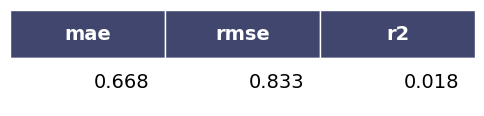

In [14]:

with mlflow.start_run():
    lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
    lr.fit(train_x, train_y)

    predicted_qualities = lr.predict(test_x)

    (rmse, mae, r2) = eval_metrics(test_y, predicted_qualities)

    print("Elasticnet model (alpha=%f, l1_ratio=%f):" % (alpha, l1_ratio))
    print("  RMSE: %s" % rmse)
    print("  MAE: %s" % mae)
    print("  R2: %s" % r2)

    mlflow.log_param("alpha", alpha)
    mlflow.log_param("l1_ratio", l1_ratio)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)

    test_x.to_csv(artifact_path+"/test.csv")
    train_x.to_csv(artifact_path+"/train.csv")
    test_y.to_csv(artifact_path+"/y_test.csv")
    pd.Series(predicted_qualities).to_csv(artifact_path+"/y_predict.csv")

    savefig(rmse,mae,r2, artifact_path)

    mlflow.log_artifact(artifact_path+"/test.csv", artifact_path="data")
    mlflow.log_artifact(artifact_path+"/train.csv", artifact_path="data")
    mlflow.log_artifact(artifact_path+"/y_test.csv", artifact_path="data")
    mlflow.log_artifact(artifact_path+"/y_predict.csv", artifact_path="data")
    mlflow.log_artifact(artifact_path+"/metrics.png", artifact_path="images")
    mlflow.set_tag('Train Size', 0.75)
    mlflow.set_tag('Test Size', 0.25)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # # Model registry does not work with file store
    # if tracking_url_type_store != "file":
    #     mlflow.sklearn.log_model(lr, "model", registered_model_name="ElasticnetWineModel")
    #     # model_info = mlflow.sklearn.log_model(lr, "model")
    # else:
    #     mlflow.sklearn.log_model(lr, "model")

### Logged Model

In [15]:
logged_model = 'runs:/8beaefcda8794fe0bbf510336e932cc6/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

RestException: RESOURCE_DOES_NOT_EXIST: Run '8beaefcda8794fe0bbf510336e932cc6' not found.

### Stage

In [ ]:
model_name = "ElasticnetWineModel"
stage = "Production"
# stage = "Staging"
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{stage}")
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'Stage: {stage} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

### Version

In [ ]:
model_name = "ElasticnetWineModel"
# version = "1"
version = "3"
loaded_model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{version}")
y_predict = loaded_model.predict(pd.DataFrame(test_x))
(rmse, mae, r2) = eval_metrics(test_y, y_predict)
print(f'Version: {version} | RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}')

### Model Serve

In [ ]:
#mlflow models serve -m "models:/ElasticnetWineModel/Production" --port 5002 --no-conda
#curl -d '{"dataframe_split": {
# "columns": ["fixed acidity","volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol"],
# "data": [[7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8]]}}' -H 'Content-Type: application/json' -X POST localhost:5002/invocations
